In [1]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyemma
import mdtraj
import scipy.spatial.distance as sdist
import numpy as np
import prody
import itertools

In [5]:
#List simulation files
data=[]
param_files=glob.glob('../Simulations_2022_04/Pulling/*.param')
for param_file in param_files:
    #Add parameters
    with open(param_file) as param:
        values={}
        for line in param:
            if len(line)==0:
                continue
            line=line.strip().split(',')
            key=line[0]
            value=line[1]
            if key=='':
                continue
            values.update({key:value})
            root='.'.join(param_file.split('.')[:-1])
            values.update({'root':root})
    #Add files
    for extension in ['param','cif','pdb','dcd','log']:
        file_name=f'{root}.{extension}'
        if os.path.exists(file_name):
            values.update({extension:file_name})
    data+=[values]
    
simulations=pd.DataFrame(data)
simulations[['epsilon']]=simulations[['epsilon']].astype(float)

simulations=simulations.sort_values(['epsilon'])
simulations=simulations.reindex()
simulations=simulations.reset_index(drop=True)
simulations

,epsilon,root,aligned,actinLen,bundleWidth,disorder,temperature,system2D,frequency,speed,...,simulation_platform,test_run,date,name,job_id,param,cif,dcd,log,layers
0,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,1
1,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,2
2,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,1000,0.05,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.05...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,NaN
3,50.0,../Simulations_2022_04/Pulling/pair_000_d_0_a_CBP,False,500,1000,0,300,False,1000,NaN,...,OpenCL,True,2022_01_19,Simulations/Pulling/pair_000_d_0_a_CBP,0,../Simulations_2022_04/Pulling/pair_000_d_0_a_...,../Simulations_2022_04/Pulling/pair_000_d_0_a_...,../Simulations_2022_04/Pulling/pair_000_d_0_a_...,../Simulations_2022_04/Pulling/pair_000_d_0_a_...,NaN
4,50.0,../Simulations_2022_04/Pulling/pair_000_d_0.2_...,False,500,1000,0,300,False,1000,NaN,...,OpenCL,True,2022_01_19,Simulations/Pulling/pair_000_d_0.2_a_CBP,0,../Simulations_2022_04/Pulling/pair_000_d_0.2_...,../Simulations_2022_04/Pulling/pair_000_d_0.2_...,../Simulations_2022_04/Pulling/pair_000_d_0.2_...,../Simulations_2022_04/Pulling/pair_000_d_0.2_...,NaN
5,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,1
6,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,NaN
7,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,2
8,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,1
9,50.0,../Simulations_2022_04/Pulling/bundle_000_e_50...,False,500,1000,0,300,False,2000,0.1,...,CUDA,True,2022_04_14,Simulations/Pulling/bundle_000_e_50_d_0_s_0.1_...,0,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,../Simulations_2022_04/Pulling/bundle_000_e_50...,NaN


In [6]:
simulations.loc[2]['root']

'../Simulations_2022_04/Pulling/bundle_000_e_50_d_0_s_0.05_a_FAS'

In [7]:
stride=1
data={}
for i,simulation in simulations.iterrows():
    
    selected_simulation=simulation

    root=selected_simulation['root']
    dcd=selected_simulation['dcd']
    cif=selected_simulation['cif']
    abp=selected_simulation['abp']

    try:
        cif=prody.parseMMCIF(selected_simulation['cif'])
    except KeyError:
        continue
        
    pdbx=mdtraj.formats.pdbx.load_pdbx(selected_simulation['cif'])
    try:
        dcd=mdtraj.load_dcd(selected_simulation['dcd'],top=pdbx)
    except OSError:
        continue
    dcd.unitcell_vectors=np.array([[[500,0,0],[0,500,0],[0,0,500]]]*len(dcd))
    
    try:
        A_bead=cif.select('resname Bead and resid 1').getIndices()
    except AttributeError:
        continue
    B_bead=cif.select('resname Bead and resid 2').getIndices()
    temp=cif.select('resname ACT ACD')
    chains=[str(a) for a in list(dict.fromkeys(temp.getChindices()))]
    resids=[str(a) for a in list(dict.fromkeys(temp.getResnums()))]
    A_pull=cif.select(f"chindex {chains[0]} and resnum {resids[0]}").getIndices()
    B_pull=cif.select(f"chindex {' '.join(chains[1:])} and resnum {resids[-1]}").getIndices()

    A=dcd[::stride].xyz[:,A_bead].mean(axis=1)
    B=dcd[::stride].xyz[:,B_bead].mean(axis=1)
    Ap=dcd[::stride].xyz[:,A_pull].mean(axis=1)
    Bp=dcd[::stride].xyz[:,B_pull].mean(axis=1)
    dA=((Ap-A)**2).sum(axis=1)**.5
    dB=((Bp-B)**2).sum(axis=1)**.5
    disp=((Bp-Ap)**2).sum(axis=1)**.5
    force=dA+dB
    data.update({i:np.array([disp,force])})

@> 11954 atoms and 1 coordinate set(s) were parsed in 0.11s.
@> 39366 atoms and 1 coordinate set(s) were parsed in 0.33s.
@> 38320 atoms and 1 coordinate set(s) were parsed in 0.32s.
@> 10284 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 39304 atoms and 1 coordinate set(s) were parsed in 0.32s.
@> 54730 atoms and 1 coordinate set(s) were parsed in 0.45s.
@> 10522 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 38822 atoms and 1 coordinate set(s) were parsed in 0.32s.
@> 34918 atoms and 1 coordinate set(s) were parsed in 0.28s.
@> 38518 atoms and 1 coordinate set(s) were parsed in 0.33s.
@> 37926 atoms and 1 coordinate set(s) were parsed in 0.32s.
@> 39910 atoms and 1 coordinate set(s) were parsed in 0.34s.
@> 38502 atoms and 1 coordinate set(s) were parsed in 0.33s.
@> 10050 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 56082 atoms and 1 coordinate set(s) were parsed in 0.47s.
@> 38734 atoms and 1 coordinate set(s) were parsed in 0.33s.
@> 38614 atoms and 1 coo

In [8]:
simulations['layers']=simulations['layers'].fillna(2)

In [9]:
#dcd=selected_simulation['dcd']
#cif=selected_simulation['cif']
#!vmd $cif

(140.0, 340.0)

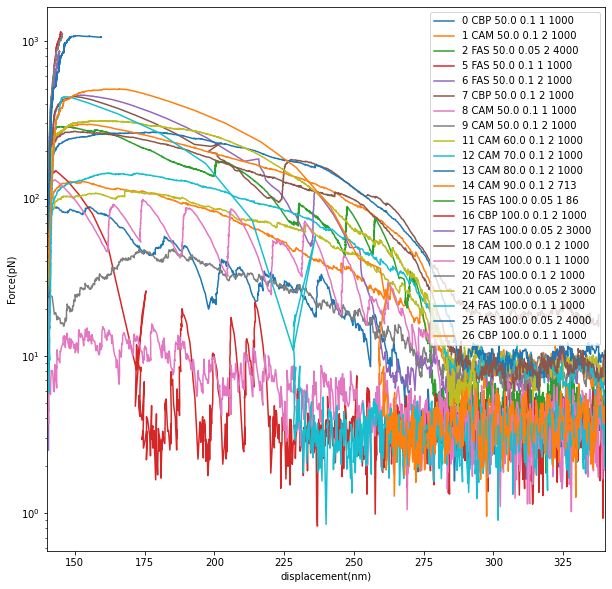

In [10]:
plt.figure(figsize=(10,10))
legend=[]
for i in data:
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{i} {simulation['abp']} {simulation['epsilon']} {simulation['speed']} {simulation['layers']} {len(data[i][0])}"]
plt.legend(legend)
plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)

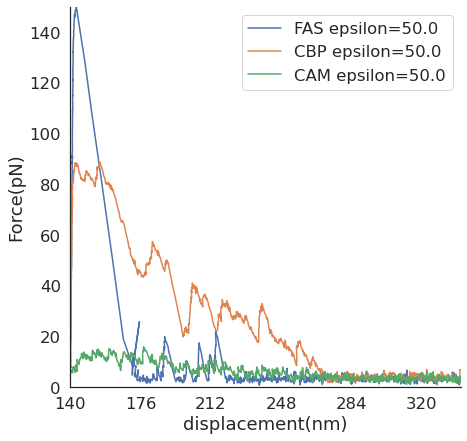

In [126]:
plt.figure(figsize=(7,7))
legend=[]
for i in [5,0,8]:
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(0,150)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.savefig('ABPpair_epsilon50.png')

In [48]:
2.82*26/2

36.66

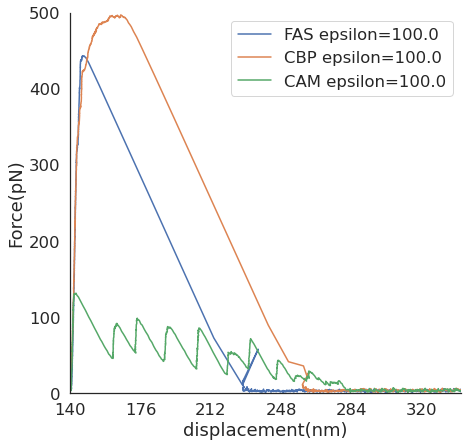

In [128]:
plt.figure(figsize=(7,7))
legend=[]
for i in [24,26,19]:
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(0,500)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.savefig('ABPpair_epsilon100.png')

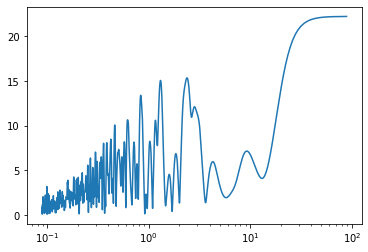

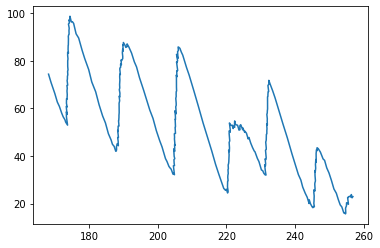

In [105]:
import scipy.signal
i=19
n=1000
x=data[i][0][200:600]/10
y=data[i][1][200:600]/1.6605
duration = x.ptp()
freqs = np.linspace(1/duration, n/duration, 5*n)
periodogram = scipy.signal.lombscargle(x, y, freqs)
plt.plot(1/freqs, np.sqrt(4*periodogram/(5*n)))
plt.semilogx()
plt.figure()
plt.plot(x, y)
#periodogram
#plt.xlim(30,40)
#plt.ylim(0,2)

In [106]:
duration

88.81229

[]

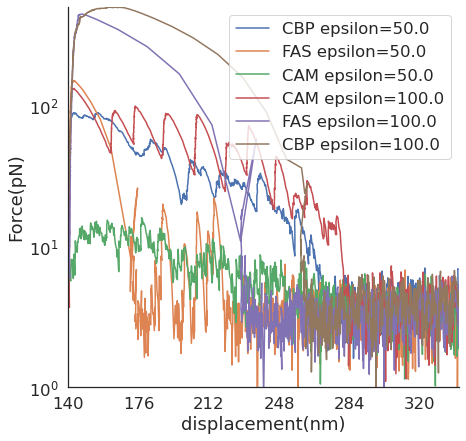

In [117]:
plt.figure(figsize=(7,7))
legend=[]
for i in data:
    if i not in [0,5,8,19,24,26]:
        continue
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(1,500)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.semilogy()
#plt.savefig('ABPpair_epsilon.png')

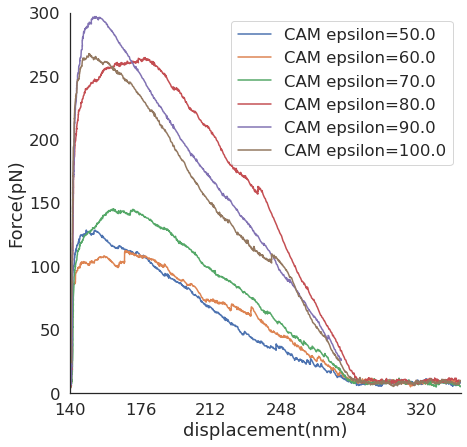

In [118]:
plt.figure(figsize=(7,7))
legend=[]
for i in data:
    if i not in [1,11,12,13,14,18]:
        continue
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(0,300)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.savefig('CAM_epsilons_speed0.1.png')

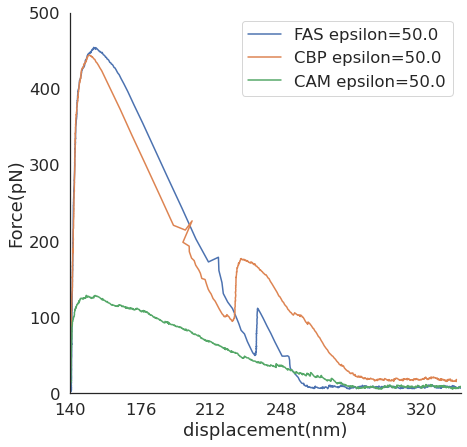

In [130]:
sns.set(style='white',font_scale=1.5)
plt.figure(figsize=(7,7))
legend=[]
for i in [6,7,1]:
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(0,500)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.savefig('ABP_epsilon50.png')

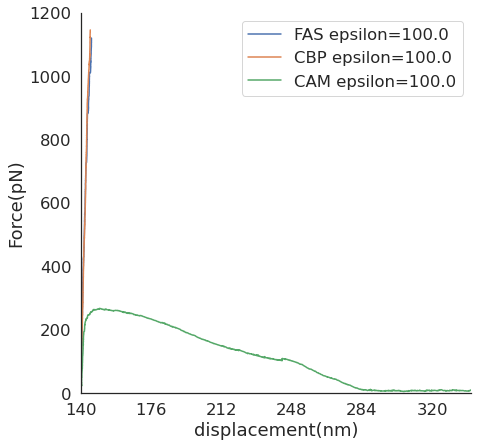

In [132]:
plt.figure(figsize=(7,7))
legend=[]
for i in [20,16,18]:
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(0,1200)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.savefig('ABP_epsilon100.png')

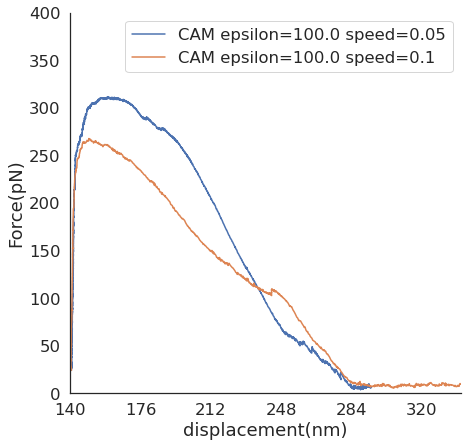

In [133]:
plt.figure(figsize=(7,7))
legend=[]
for i in [21,18]:
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{simulation['abp']} epsilon={simulation['epsilon']} speed={simulation['speed']}"]
plt.legend(legend)
#plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(0,400)
plt.xticks([140+36*i for i in range(6)])
sns.despine()
plt.savefig('CAM_speed.png')

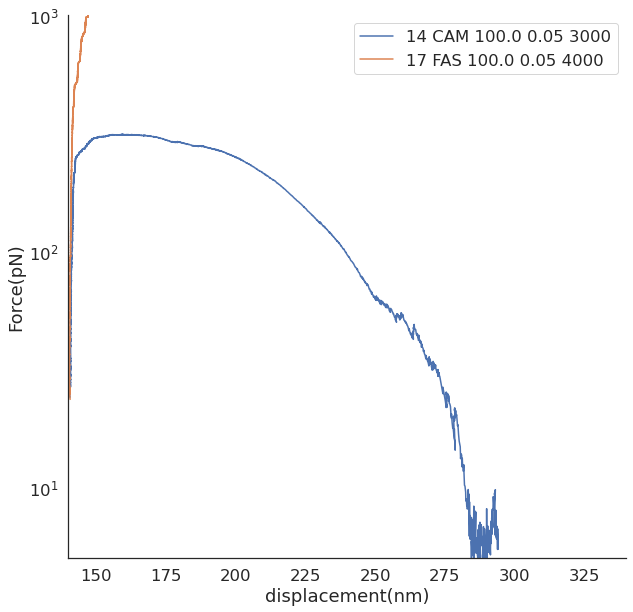

In [292]:
plt.figure(figsize=(10,10))
legend=[]
for i in data:
    if i not in [14,17]:
        continue
    plt.plot(data[i][0]/10,data[i][1]/1.6605)#Force from kJ/mol/nm to pN
    simulation=simulations.loc[i]
    legend+=[f"{i} {simulation['abp']} {simulation['epsilon']} {simulation['speed']} {len(data[i][0])}"]
plt.legend(legend)
plt.semilogy()
plt.xlabel('displacement(nm)')
plt.ylabel('Force(pN)')
plt.xlim(140,340)
plt.ylim(5,1E3)
sns.despine()
#plt.savefig('ABP_epsilon50.png')

In [207]:
min(data[i][0]/10)

139.9726

In [208]:
simulation

epsilon                                                              100
root                   ../Simulations/Pulling/bundle_000_e_100_d_0_s_...
aligned                                                            False
actinLen                                                             500
bundleWidth                                                         1000
disorder                                                               0
temperature                                                          300
system2D                                                           False
frequency                                                           1000
speed                                                               0.05
abp                                                                  FAS
simulation_platform                                                 CUDA
test_run                                                            True
date                                               

In [209]:
B_pull.getIndices()

AttributeError: 'numpy.ndarray' object has no attribute 'getIndices'

In [5]:
stride=5

for i,simulation in simulations.iterrows():
    
    selected_simulation=simulation

    root=selected_simulation['root']
    dcd=selected_simulation['dcd']
    cif=selected_simulation['cif']
    abp=selected_simulation['abp']
    #!vmd -e ../Box_vis_500.vmd $cif $dcd
    
    try:
        cif=prody.parseMMCIF(selected_simulation['cif'])
    except KeyError:
        continue
    pdbx=mdtraj.formats.pdbx.load_pdbx(selected_simulation['cif'])
    dcd=mdtraj.load_dcd(selected_simulation['dcd'],top=pdbx)
    dcd.unitcell_vectors=np.array([[[500,0,0],[0,500,0],[0,0,500]]]*len(dcd))

    s={}
    for name in ['Aa','Ab','Ac','Ca','Cb','Cd']:
        selection=cif.select(f'name {name}')
        #dcd.setAtoms(selection)
        s.update({name:selection.getIndices()})
    #d1=np.array([sdist.cdist(a,b) for a,b in zip(s['Aa'],s['Ca'])])
    #d2=np.array([sdist.cdist(a,b) for a,b in zip(s['Ab'],s['Cb'])])
    #d3=np.array([sdist.cdist(a,b) for a,b in zip(s['Ac'],s['Cd'])])

    selection=cif.select('name Ca')

    d1=mdtraj.compute_distances(dcd[::stride],np.array([a for a in itertools.product(s['Aa'],s['Ca'])]),periodic=True)
    d2=mdtraj.compute_distances(dcd[::stride],np.array([a for a in itertools.product(s['Ab'],s['Cb'])]),periodic=True)
    d3=mdtraj.compute_distances(dcd[::stride],np.array([a for a in itertools.product(s['Ac'],s['Cd'])]),periodic=True)

    actin_com=(dcd[::stride].xyz[:,s['Aa']]+dcd[::stride].xyz[:,s['Ab']]+dcd[::stride].xyz[:,s['Ac']])/3
    abp_com=(dcd[::stride].xyz[:,s['Ca']]+dcd[::stride].xyz[:,s['Cb']]+dcd[::stride].xyz[:,s['Cd']])/3
    translation=np.expand_dims(abp_com,axis=1)-np.expand_dims(actin_com,axis=2)
    rmsd_abp=((((np.expand_dims(dcd[::stride].xyz[:,s['Ca']],axis=1)-translation-np.expand_dims(dcd[::stride].xyz[:,s['Aa']],axis=2))**2).sum(axis=3)+
               ((np.expand_dims(dcd[::stride].xyz[:,s['Cb']],axis=1)-translation-np.expand_dims(dcd[::stride].xyz[:,s['Ab']],axis=2))**2).sum(axis=3)+
               ((np.expand_dims(dcd[::stride].xyz[:,s['Cd']],axis=1)-translation-np.expand_dims(dcd[::stride].xyz[:,s['Ac']],axis=2))**2).sum(axis=3))/3)**.5
    rmsd_abp.shape

    dd=(d1**2+d2**2+d3**2)/3
    g1=-1*(np.exp(-dd/1.0)+np.exp(-dd/0.01*1.0))/2*(d1<12.0)
    g1.shape

    g2=g1.reshape(len(g1),len(s['Aa']),len(s['Ca']))
    g2.shape

    g3_total_bind = (g2<-0.2).sum(axis=1).T>0
    g3_partial_bind = (g2<0).sum(axis=1).T > 0
    g3_states=[g3_total_bind[:,0]]
    for t in range(1,len(g3_total_bind.T)):
        g3_state=g3_total_bind[:,t] | (g3_states[-1] & g3_partial_bind[:,t])
        g3_states+=[g3_state]
    g3=np.array(g3_states).T
    Actin_binding=g3*1

    g3_total_bind = (g2<-0.2).sum(axis=2).T>0
    g3_partial_bind = (g2<0).sum(axis=2).T > 0
    g3_states=[g3_total_bind[:,0]]
    for t in range(1,len(g3_total_bind.T)):
        g3_state=g3_total_bind[:,t] | (g3_states[-1] & g3_partial_bind[:,t])
        g3_states+=[g3_state]
    g3=np.array(g3_states).T
    ABP_binding=g3*1


    Actin_binding[0].sum()

    Actin_binding_pair=g2.argmin(axis=1).T
    ABP_binding_pair=g2.argmin(axis=2).T
    Actin_binding_pair[Actin_binding==0]=-99999
    ABP_binding_pair[ABP_binding==0]=-99999

    plt.figure(figsize=(10,5))
    fig,ax=pyemma.plots.plot_free_energy(np.log10((dd**.5).ravel()),rmsd_abp.ravel(),cmap='viridis')
    ax.set_xlim(-1.5,2.5)
    ax.set_ylim(0,2)
    ax.set_xticklabels([rf'$10^{{{i}}}$' for i in range(-3,5)])
    ax.set_xlabel('ABP-Binding site distance (nm)')
    ax.set_ylabel('ABP-Binding site RMSD (nm)')
    plt.savefig(f'{root}_Freeenergy.png')
    break

@> 38822 atoms and 1 coordinate set(s) were parsed in 0.33s.


AttributeError: 'NoneType' object has no attribute 'getIndices'

In [7]:
abp

'CAM'

@> 10480 atoms and 1 coordinate set(s) were parsed in 0.09s.


Text(0, 0.5, 'Energy')

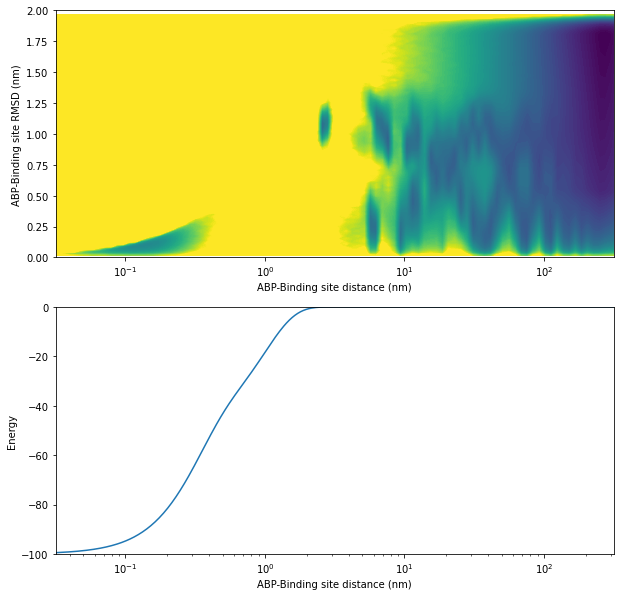

In [223]:
selected_simulation=simulations.loc[0]

root=selected_simulation['root']
dcd=selected_simulation['dcd']
cif=selected_simulation['cif']
#!vmd -e ../Box_vis_500.vmd $cif $dcd


cif=prody.parseMMCIF(selected_simulation['cif'])
pdbx=mdtraj.formats.pdbx.load_pdbx(selected_simulation['cif'])
dcd=mdtraj.load_dcd(selected_simulation['dcd'],top=pdbx)
dcd.unitcell_vectors=np.array([[[500,0,0],[0,500,0],[0,0,500]]]*len(dcd))

s={}
for name in ['Aa','Ab','Ac','Ca','Cb','Cd']:
    selection=cif.select(f'name {name}')
    #dcd.setAtoms(selection)
    s.update({name:selection.getIndices()})
#d1=np.array([sdist.cdist(a,b) for a,b in zip(s['Aa'],s['Ca'])])
#d2=np.array([sdist.cdist(a,b) for a,b in zip(s['Ab'],s['Cb'])])dd_temp
#d3=np.array([sdist.cdist(a,b) for a,b in zip(s['Ac'],s['Cd'])])

selection=cif.select('name Ca')

d1=mdtraj.compute_distances(dcd[::stride],np.array([a for a in itertools.product(s['Aa'],s['Ca'])]),periodic=True)
d2=mdtraj.compute_distances(dcd[::stride],np.array([a for a in itertools.product(s['Ab'],s['Cb'])]),periodic=True)
d3=mdtraj.compute_distances(dcd[::stride],np.array([a for a in itertools.product(s['Ac'],s['Cd'])]),periodic=True)

actin_com=(dcd[::stride].xyz[:,s['Aa']]+dcd[::stride].xyz[:,s['Ab']]+dcd[::stride].xyz[:,s['Ac']])/3
abp_com=(dcd[::stride].xyz[:,s['Ca']]+dcd[::stride].xyz[:,s['Cb']]+dcd[::stride].xyz[:,s['Cd']])/3
translation=np.expand_dims(abp_com,axis=1)-np.expand_dims(actin_com,axis=2)
rmsd_abp=((((np.expand_dims(dcd[::stride].xyz[:,s['Ca']],axis=1)-translation-np.expand_dims(dcd[::stride].xyz[:,s['Aa']],axis=2))**2).sum(axis=3)+
           ((np.expand_dims(dcd[::stride].xyz[:,s['Cb']],axis=1)-translation-np.expand_dims(dcd[::stride].xyz[:,s['Ab']],axis=2))**2).sum(axis=3)+
           ((np.expand_dims(dcd[::stride].xyz[:,s['Cd']],axis=1)-translation-np.expand_dims(dcd[::stride].xyz[:,s['Ac']],axis=2))**2).sum(axis=3))/3)**.5
rmsd_abp.shape

dd=(d1**2+d2**2+d3**2)/3
g1=-1*(np.exp(-dd/1.0)+np.exp(-dd/0.01*1.0))/2*(d1<12.0)
g1.shape

g2=g1.reshape(len(g1),len(s['Aa']),len(s['Ca']))
g2.shape

g3_total_bind = (g2<-0.2).sum(axis=1).T>0
g3_partial_bind = (g2<0).sum(axis=1).T > 0
g3_states=[g3_total_bind[:,0]]
for t in range(1,len(g3_total_bind.T)):
    g3_state=g3_total_bind[:,t] | (g3_states[-1] & g3_partial_bind[:,t])
    g3_states+=[g3_state]
g3=np.array(g3_states).T
Actin_binding=g3*1

g3_total_bind = (g2<-0.2).sum(axis=2).T>0
g3_partial_bind = (g2<0).sum(axis=2).T > 0
g3_states=[g3_total_bind[:,0]]
for t in range(1,len(g3_total_bind.T)):
    g3_state=g3_total_bind[:,t] | (g3_states[-1] & g3_partial_bind[:,t])
    g3_states+=[g3_state]
g3=np.array(g3_states).T
ABP_binding=g3*1


Actin_binding[0].sum()

Actin_binding_pair=g2.argmin(axis=1).T
ABP_binding_pair=g2.argmin(axis=2).T
Actin_binding_pair[Actin_binding==0]=-99999
ABP_binding_pair[ABP_binding==0]=-99999

fig,(ax1,ax2)=plt.subplots(2,figsize=(10,10))
fig,ax=pyemma.plots.plot_free_energy(np.log10((dd**.5).ravel()),rmsd_abp.ravel(),cmap='viridis',
                                     ax=ax1,cbar=False,vmin=0,vmax=12)
#ax.set_xlim(-3,4)
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(0,2)
ax1.set_xticks(np.arange(-1,3))
ax1.set_xticklabels([rf'$10^{{{round(i,1)}}}$' for i in np.arange(-1,3)])
ax1.set_xlabel('ABP-Binding site distance (nm)')
ax1.set_ylabel('ABP-Binding site RMSD (nm)')
epsilon=float(selected_simulation['epsilon'])
w1=float(selected_simulation['w1'])
w2=float(selected_simulation['w1'])*float(selected_simulation['w2_ratio'])

x=np.logspace(-2,3,500)
y=-epsilon*(np.exp(-x**2/w1)+np.exp(-x**2/w2))/2*(x<120)
ax2.plot(x,y)
ax2.set_ylim(-epsilon,0)
ax2.set_xlim(10**-1.5,10**2.5)
ax2.semilogx()
ax2.set_xlabel('ABP-Binding site distance (nm)')
ax2.set_ylabel('Energy')

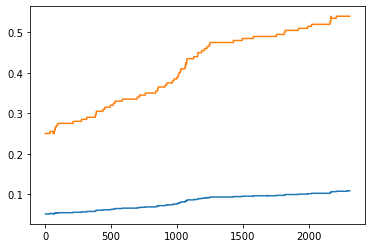

In [224]:
plt.plot(ABP_binding.sum(axis=0)/len(ABP_binding))
plt.plot(Actin_binding.sum(axis=0)/len(Actin_binding))

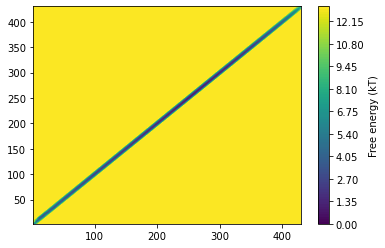

In [212]:
fig,ax=pyemma.plots.plot_free_energy((dd**.5).ravel(),d1.ravel(),cmap='viridis')

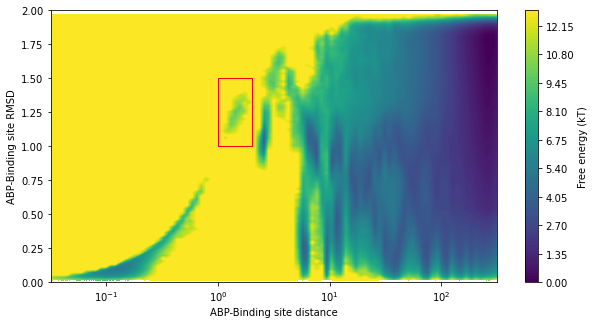

In [201]:
import matplotlib.patches as patches
plt.figure(figsize=(10,5))
fig,ax=pyemma.plots.plot_free_energy(np.log10((dd**.5).ravel()),rmsd_abp.ravel(),cmap='viridis')
ax.set_xlim(-1.5,2.5)
ax.set_ylim(0,2)
ax.set_xticks(np.arange(-1,3))
ax.set_xticklabels([rf'$10^{{{round(i,1)}}}$' for i in np.arange(-1,3)])
ax.set_xlabel('ABP-Binding site distance')
ax.set_ylabel('ABP-Binding site RMSD')
dd_lims=(1,2) #Square1
rmsd_lims=(1,1.5) #Square1
#dd_lims=(2,4) #Square2
#rmsd_lims=(0.7,1.75) #Square2

rect = patches.Rectangle((np.log10(dd_lims[0]), rmsd_lims[0]), 
                         np.log10(dd_lims[1])-np.log10(dd_lims[0]), 
                         rmsd_lims[1]-rmsd_lims[0], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

<AxesSubplot:>

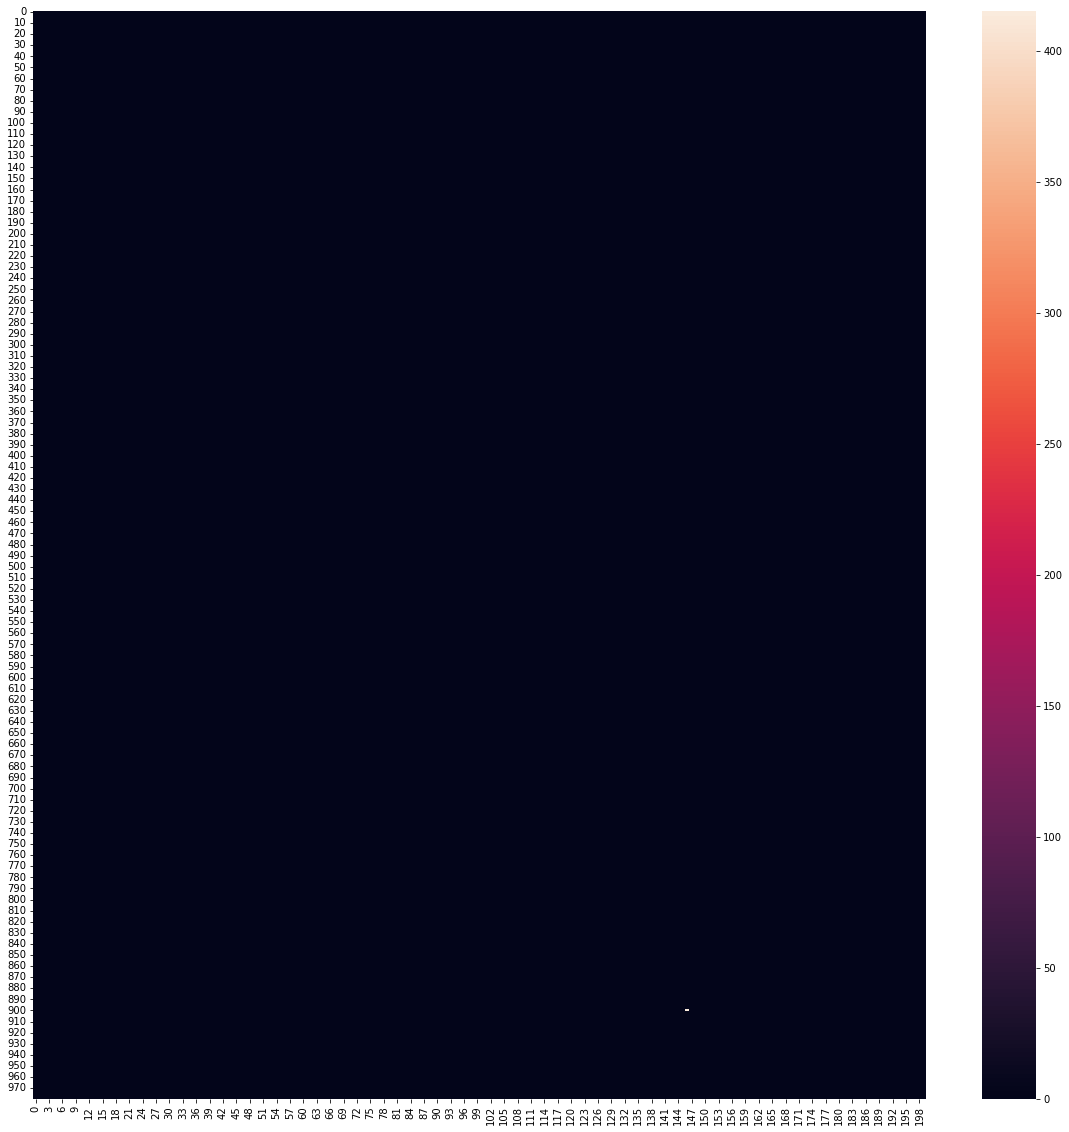

In [202]:
dd_temp=(dd**.5).reshape(rmsd_abp.shape)
selection=((dd_temp>=dd_lims[0]) & (dd_temp<=dd_lims[1]) & (rmsd_abp>=rmsd_lims[0]) & (rmsd_abp<=rmsd_lims[1])).reshape(rmsd_abp.shape)
plt.figure(figsize=(20,20))
sns.heatmap(selection.sum(axis=0))

In [203]:
selection.sum(),selection.sum(axis=0).max()

(415, 415)

(900, 146)
890


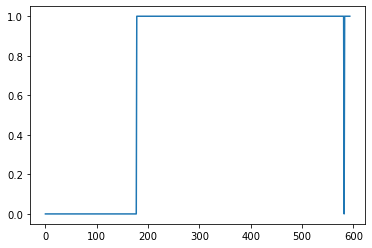

In [204]:
example_binding=np.unravel_index(selection.sum(axis=0).argmax(),selection.shape[1:])
print(example_binding)
plt.plot(selection[:,example_binding[0],example_binding[1]])
print(selection[:,example_binding[0],example_binding[1]].argmax()*5)

In [205]:
print(s['Aa'][example_binding[0]],s['Ab'][example_binding[0]],s['Ac'][example_binding[0]],
      s['Ca'][example_binding[1]],s['Cb'][example_binding[1]],s['Cd'][example_binding[1]])


9083 9084 9085 10318 10319 10320


In [207]:
dcd=selected_simulation['dcd']
cif=selected_simulation['cif']
!vmd -e ../Box_vis_500.vmd $cif $dcd

Info) VMD for LINUXAMD64, version 1.9.4a55 (October 19, 2021)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 12 CPUs, ISA dispatch enabled.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info) Free system memory: 42GB (66%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator::
Info) [0] NVIDIA GeForce RTX 3080 Ti 80 SM_8.6 1.7 GHz, 12GB RAM SP32 KT AE2 ZC
Info) OpenGL renderer: NVIDIA GeForce RTX 3080 Ti/PCIe/SSE2
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS GLSL(OVFGS) 
Info)   Full GLSL rendering mode is available.
Info)   Tex

In [275]:
#Stay time
#Kon ->per ABP site/per ABP
#Koff
#1D Diffusion


g1.shape

(705, 196000)

In [276]:
g1.sum(axis=0).argmin()

97883

In [277]:
d1.max(),d1.min()

(432.53467, 0.04042675)

(-1.0, 0.0)

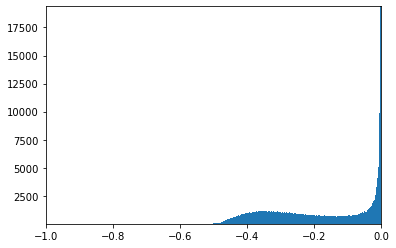

In [550]:
import matplotlib.pyplot as plt
%matplotlib inline
h=plt.hist(g1.ravel(),bins=500)
#plt.semilogy()
plt.ylim(1,h[0][:-1].max())
plt.xlim(-1,0)

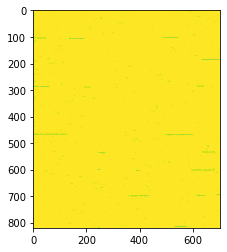

In [126]:
plt.imshow(g1[:,g1.sum(axis=0)<0].T)

In [25]:
import pyemma
pyemma.__version__

'2.4'

In [157]:
temp=g1[:,g1.sum(axis=0)<0].T<0
temp=temp.astype(int)
for lag in range(1,20):
    msm=pyemma.msm.estimate_markov_model(temp.tolist(),lag=lag)
    print(msm.transition_matrix)

[[0.99748292 0.00251708]
 [0.73532338 0.26467662]]
[[0.99736444 0.00263556]
 [0.78198108 0.21801892]]
[[0.99735022 0.00264978]
 [0.79720976 0.20279024]]
[[0.99730454 0.00269546]
 [0.8159601  0.1840399 ]]
[[0.99728145 0.00271855]
 [0.82875686 0.17124314]]
[[0.99728456 0.00271544]
 [0.83416583 0.16583417]]
[[0.99725963 0.00274037]
 [0.84792396 0.15207604]]
[[0.99729608 0.00270392]
 [0.8432649  0.1567351 ]]
[[0.99724999 0.00275001]
 [0.85914787 0.14085213]]
[[0.99728302 0.00271698]
 [0.85283777 0.14716223]]
[[0.99725795 0.00274205]
 [0.86260694 0.13739306]]
[[0.9972434 0.0027566]
 [0.8698941 0.1301059]]
[[0.99722174 0.00277826]
 [0.87670541 0.12329459]]
[[0.9972372  0.0027628 ]
 [0.87348178 0.12651822]]
[[0.9972527  0.0027473 ]
 [0.87031408 0.12968592]]
[[0.99722029 0.00277971]
 [0.88235294 0.11764706]]
[[0.99722336 0.00277664]
 [0.88268156 0.11731844]]
[[0.99718369 0.00281631]
 [0.89730554 0.10269446]]
[[0.99721347 0.00278653]
 [0.89013225 0.10986775]]


In [99]:
np.asscalar(g1)

/home/cb/miniconda3/envs/openmm_dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


ValueError: can only convert an array of size 1 to a Python scalar

In [94]:
np.random.choice(g1[:1000].ravel(),100)

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.], dtype=float32)

In [95]:
np.array([[[1,0,0],[0,1,0],[0,0,1]]]*len(dcd)).shape

(38, 3, 3)

In [13]:
dcd.unitcell_distances.

(15829,)